# **Measuring Bias in regression**


This notebook is a tutorial on auditing bias within a regression task. We will use the holisticai library thoughout, introducing some of the functions we have created to help study algorithmic bias.

The sections are organised as follows :
1. Load the data : we load the student grades dataset as a pandas DataFrame
2. Data Exploration : some preliminary analysis of the data
3. Train a Model : we train a simple linear regression model (sklearn)
4. Measure Bias : we compute a few bias metrics, and comment on their meaning

## **Load the data**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai[all]
```

In [5]:
# Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

We host a few example datasets on the holisticai library for quick loading and experimentation. Here we load and use the Student dataset. The goal of this dataset is the prediction of the numerical attribute 'G3' (mathematics grade of student in 3rd trimester). There are a number of sensitive attributes in this dataset, some of which are : sex, address, Mjob (mother's job), Fjob (father's job)...

Although the `load_dataset` function returns a preprocessed version, in this opportunity we will perform this processing by ourselves since the default preprocessing is more suitable for multiclassification tasks.

In [6]:
from holisticai.datasets import load_dataset
df = load_dataset(dataset='student', preprocessed=False, as_array=False)['frame']
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


## **Data Exploration**

We import some of the holisticai plotters for quick exploration of the data.

In [7]:
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import distribution_plot
from holisticai.bias.plots import success_rate_curves

<Axes: >

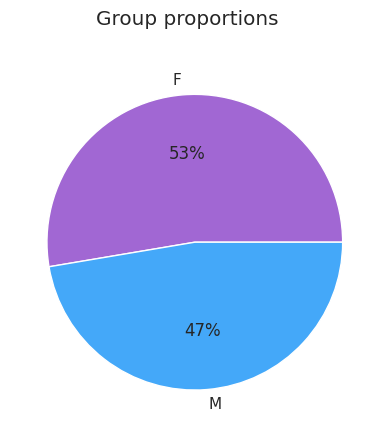

In [8]:
group_pie_plot(df['sex'])

The data is balanced in terms of sex.

<Axes: xlabel='G3', ylabel='Density'>

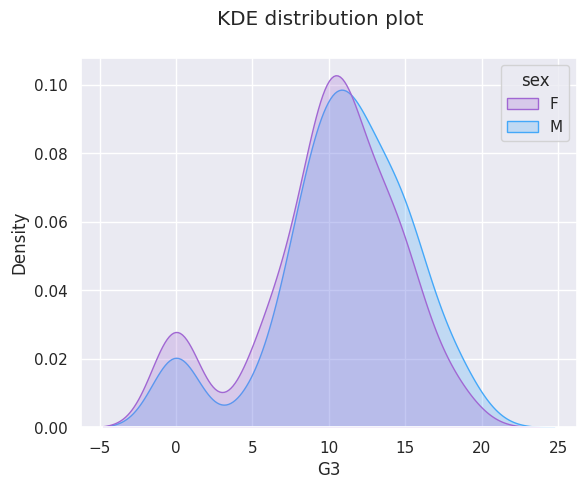

In [9]:
# distribution of grades for male an female
distribution_plot(df['G3'], df['sex'])

The grades are fairly similar for both sex subgroups, showing a slight difference with density of male grades in the 12 to 20 range being higher.

<Axes: xlabel='G3', ylabel='Density'>

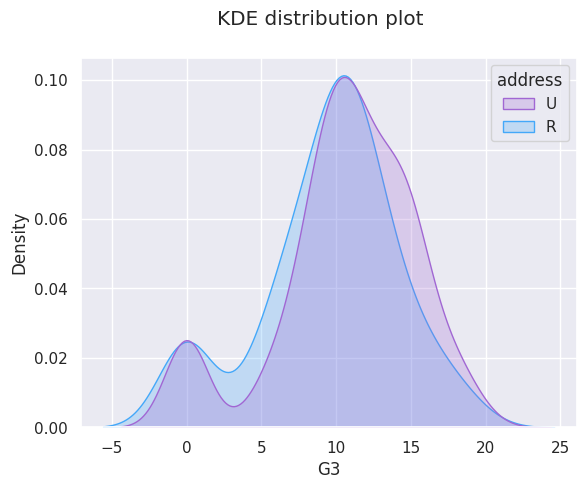

In [10]:
# distribution of grades for urban and rural
distribution_plot(df['G3'], df['address'])

The distributions for different addresses (Urban vs Rural) show more difference, with Rural grades having higher density at lower grades.

<Axes: xlabel='G3', ylabel='Density'>

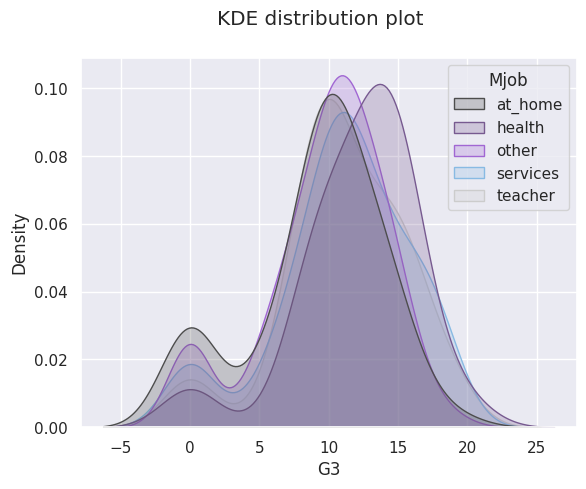

In [11]:
# distribution of grades for different Mother jobs
distribution_plot(df['G3'], df['Mjob'])

The Mother's job attribute is the one that shows most difference in the densities of grades. For instance we observe students with a mother working in health have higher density at higher grades.

<Axes: xlabel='Score'>

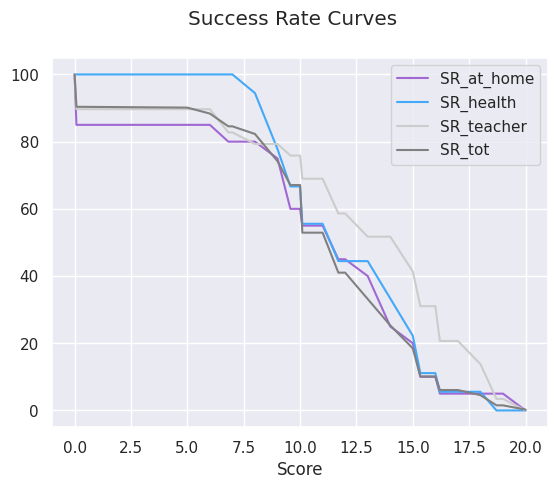

In [12]:
p_attr = np.array(df['Fjob'])
y =      np.array(df['G3'])
success_rate_curves(p_attr, y, groups=['at_home', 'health', 'teacher'])

The above shows the success rate (sucess is exceeding the given threshold) as a function of threshold for different subgroups of the population : Father's job in ['at_home', 'health', 'teacher']. We can observe that student's with a parent as a teacher are more likely to exceed high thresholds than other groups.

## **Preprocess Data and Train a model**

We use a sklearn linear regression model.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [14]:
# we don't want to encode protected attributes
protected_attributes = ['sex', 'address', 'Mjob', 'Fjob']
label_attributes = ['G3', 'G2', 'G1']

# preprocess categorical columns
def preprocess_data(data, protected_attributes, label_attributes):
    categoricals = []
    for col in data.columns:
        if col not in protected_attributes and col not in label_attributes and data[col].dtype == object:
            categoricals.append(col)

    cat_encoder = OneHotEncoder()  
    enc = cat_encoder.fit_transform(data[categoricals])
    enc = pd.DataFrame(enc.toarray())
    df = pd.concat([data,enc],axis=1).drop(columns=categoricals) # add encoded columns
    
    df = df.rename(str, axis='columns')
    return df

In [15]:
# Load, preprocess and split for training
data = df
preproc_data = preprocess_data(data, protected_attributes, label_attributes)
train, test = train_test_split(preproc_data, test_size=0.3, random_state=42)


In [16]:
# G3 is the students final grade (drop G2 and G1 as well because highly correlated with G3)
X_train = train.drop(columns=label_attributes)
X_test = test.drop(columns=label_attributes)
y_train = train['G3']
y_test = test['G3']

# Train a simple linear regression model
LR = LinearRegression()
model = LR.fit(X_train.drop(columns=protected_attributes), y_train)

# Predict values
y_pred = model.predict(X_test.drop(columns=protected_attributes))

In [17]:
from holisticai.efficacy.metrics import regression_efficacy_metrics

regression_efficacy_metrics(y_pred, y_test)

,Value,Reference
Metric,,
RMSE,4.368049,0
MAE,3.479379,0
MAPE,0.371381,0
Max Error,11.447021,0
SMAPE,0.212660,0


## **Measure bias**

In [18]:
# import some bias metrics
from holisticai.bias.metrics import statistical_parity_regression
from holisticai.bias.metrics import disparate_impact_regression
from holisticai.bias.metrics import mae_ratio
from holisticai.bias.metrics import rmse_ratio

In [19]:
# set up vectors for gender

group_a = np.array(X_test['sex']=='M')
group_b = np.array(X_test['sex']=='F')
y_pred  = np.array(model.predict(X_test.drop(columns=protected_attributes)))
y_true  = np.array(y_test)

In [20]:
# evaluate fairness metrics for gender
print ('Statistical Parity Q80   : ' + str(statistical_parity_regression(group_a, group_b, y_pred, q=0.8)))
print ('Disparate Impact Q80     : ' + str(disparate_impact_regression(group_a, group_b, y_pred, q=0.8)))
print ('MAE Ratio                : ' + str(mae_ratio(group_a, group_b, y_pred, y_true)))
print ('RMSE Ratio               : ' + str(rmse_ratio(group_a, group_b, y_pred, y_true)))

Statistical Parity Q80   : 0.02345958168456755
Disparate Impact Q80     : 1.1236959761549925
MAE Ratio                : 0.9141144276916645
RMSE Ratio               : 0.8663715815884354


All the above metrics are within acceptable ranges. This shows there isn't much bias for the subgroups of the sex column. Let's try the address attribute.

In [21]:
# set up vectors for address

group_a = np.array(X_test['address']=='U')
group_b = np.array(X_test['address']=='R')
y_pred  = np.array(model.predict(X_test.drop(columns=protected_attributes)))
y_true  = np.array(y_test)

In [22]:
# evaluate fairness metrics for address
print ('Statistical Parity Q80   : ' + str(statistical_parity_regression(group_a, group_b, y_pred, q=0.8)))
print ('Disparate Impact Q80     : ' + str(disparate_impact_regression(group_a, group_b, y_pred, q=0.8)))
print ('MAE Ratio                : ' + str(mae_ratio(group_a, group_b, y_pred, y_true)))
print ('RMSE Ratio               : ' + str(rmse_ratio(group_a, group_b, y_pred, y_true)))

Statistical Parity Q80   : 0.10488505747126436
Disparate Impact Q80     : 1.839080459770115
MAE Ratio                : 0.9038418324219878
RMSE Ratio               : 0.9326932829601493


The disparate impact at quantile 0.8 is outside of fair ranges (0.8, 1.2), students living in urban areas are 1.8 times more likely to be predicted in top 20% of grades than students living in rural areas.

In [23]:
print ('Disparate Impact Q80     : ' + str(disparate_impact_regression(group_a, group_b, y_true, q=0.8)))

Disparate Impact Q80     : 4.2298850574712645


When we look at the metric computed on true values, we get an even worst pattern. Students living in urban areas are actually 4.2 times more likely to be in top 20% of grades than students living in rural areas.

**Equality of outcome metrics (batch computation)**

Use address as protected attribute

In [24]:
# set up vectors for address

group_a = np.array(X_test['address']=='U')
group_b = np.array(X_test['address']=='R')
y_pred  = np.array(model.predict(X_test.drop(columns=protected_attributes)))

In [25]:
from holisticai.bias.metrics import regression_bias_metrics
regression_bias_metrics(group_a, group_b, y_pred, metric_type='equal_outcome')

,Value,Reference
Metric,,
Disparate Impact Q90,1.103448,1
Disparate Impact Q80,1.839080,1
Disparate Impact Q50,1.208539,1
Statistical Parity Q50,0.104885,0
No Disparate Impact Level,13.555553,-
Average Score Difference,0.618144,0
Average Score Ratio,1.061075,1
Z Score Difference,0.274708,0
Max Statistical Parity,0.206178,0


**Equality of opportunity metrics (batch computation)**

Use address as protected attribute

In [26]:
# set up vectors for address

group_a = X_test['address']=='U'
group_b = X_test['address']=='R'
y_pred  = model.predict(X_test.drop(columns=protected_attributes))
y_true  = y_test

In [27]:
regression_bias_metrics(group_a, group_b, y_pred, y_true, metric_type='equal_opportunity')

,Value,Reference
Metric,,
RMSE Ratio,0.932693,1
RMSE Ratio Q80,0.818926,1
MAE Ratio,0.903842,1
MAE Ratio Q80,0.756853,1
Correlation Difference,0.214900,0


In [28]:
regression_bias_metrics(group_a=group_a, group_b=group_b, y_pred=y_pred, y_true=y_true, metric_type='both')

,Value,Reference
Metric,,
Disparate Impact Q90,1.103448,1
Disparate Impact Q80,1.839080,1
Disparate Impact Q50,1.208539,1
Statistical Parity Q50,0.104885,0
No Disparate Impact Level,13.555553,-
Average Score Difference,0.618144,0
Average Score Ratio,1.061075,1
Z Score Difference,0.274708,0
Max Statistical Parity,0.206178,0


We can show all individual bias metrics by setting 'metric_types' as 'individual'.

In [29]:
regression_bias_metrics(group_a=group_a, group_b=group_b, y_pred=y_pred, y_true=y_true, metric_type='individual')

,Value,Reference
Metric,,
Jain Index,0.634495,1
